<h2>Project 8: Deep Learning</h2>


<h3>Introduction</h3>
In this project, you will implement a neural network.
We broke it apart into several functions and a pre-processing step.</p>

  <p> 
  An important step to make neural networks function properly is to scale the data properly. Therefore, first implement the preprocess function
  It takes as input the training and the test data and transforms them both with the same mapping: $\vec x_i\rightarrow U\vec x_i-\vec{m}$. 
  After this transformation the training data set should have zero-mean and each feature should have standard deviation 1 . The same transformation is then also applied to the test data (Hint: The matrix U is typically diagonal.) 
  <!--	 <li>HINT 2: Ideally you would like the input features to be de-correlated. The correlation matrix should be diagonal (in this case even the identity matrix). One way to do this is to project the data onto the PCA principal components (which we will still cover later in the course). You can get the transposed projection matrix by calling $pcacov(xTr')$. Make sure to apply PCA <i>after</i> you subtracted off the mean. </li>-->
  </p>

In [24]:
import numpy as np
from numpy.matlib import repmat
import sys
import matplotlib.pyplot as plt
from scipy.io import loadmat
import time


from l2distance import l2distance
from visclassifier import visclassifier

%matplotlib inline

In [25]:
def preprocess(xTr, xTe):
    """function [xTr,xTe,u,m]=preprocess(xTr,xTe);

    Preproces the data to make the training features have zero-mean and
    standard-deviation 1

    output:
    xTr - pre-processed training data 
    xTe - pre-processed testing data

    s,m - any other data should be pre-processed by x-> s*(x-m)
    """
    
    ntr, d = xTr.shape
    nte, _ = xTe.shape
    
    m = xTr.mean(axis=0)

    xTr = xTr - repmat(m, ntr, 1)
    xTe = xTe - repmat(m, nte, 1)

    s = xTr.std(axis=0)
    s[s == 0] = 1

    xTr /= repmat(s, ntr, 1)
    xTe /= repmat(s, nte, 1)
    
    return xTr, xTe, s, m

In [26]:
def get_transition_func(transtype):
    """
    Given the type, gets a specific transition function
      INPUT
      type "sigmoid", "tanh", "ReLU"
      OUTPUT
      trans_func transition function (function)
      trans_func_der derivative of the transition function (function)

    type must be one of the defined transition functions            
    """
    
    assert transtype in ["sigmoid", "tanh", "ReLU","sin"]
    if transtype == "sin":   
        trans_func = lambda z: np.sin(z)
        trans_func_der = lambda z: np.cos(z)   
    if transtype == "sigmoid":
        trans_func = lambda z: 1 / (1 + np.exp(-z))
        trans_func_der = lambda z: trans_func(z) * (1 - trans_func(z))
    if transtype == "ReLU":
        trans_func = lambda z: np.maximum(z, 0)
        trans_func_der = lambda z: (z >= 0) + 0
    if transtype == "tanh":
        trans_func = lambda z: np.tanh(z)
        trans_func_der = lambda z: 1 - trans_func(z) ** 2
    
    return trans_func, trans_func_der

<p>If everything is correct we can now plot these functions and check their gradients. The gradient errors should all be very small (less than $10^{-10}$.) </p>

In [27]:
def numericalgradient(fun,x,e):
    dh = 0
    nx = x    # copy the weight vector
    nx += e  # perturn dimension i
    l1 = fun(nx) # compute loss
    nx -= 2*e # perturm dimension i again
    l2 = fun(nx) # compute loss
    dh = (l1 - l2)/(2*e) # the gradient is the slope of the loss
    return dh

sigmoid gradient check at x=1: passed at x=-1: passed
tanh gradient check at x=1: passed at x=-1: passed
ReLU gradient check at x=1: passed at x=-1: passed
sin gradient check at x=1: passed at x=-1: passed


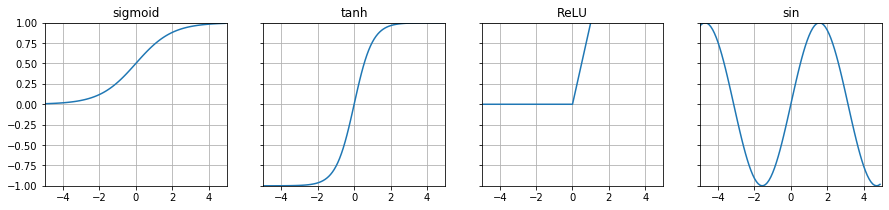

In [28]:
fig, axarr = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_figwidth(15)
fig.set_figheight(3)
names = ["sigmoid","tanh","ReLU","sin"]

for idx, name in enumerate(names):
    # plot stuff
    f, delta_f = get_transition_func(name)
    x = np.arange(-5, 5, 0.1)
    axarr[idx].plot(x, f(x))
    axarr[idx].axis([-5,5,-1,1])
    axarr[idx].title.set_text(name)
    axarr[idx].grid(True)
    
    # check gradients
    print("%s gradient check at x=1: " % name, end='')
    dh = numericalgradient(f,1,1e-5)
    dy = delta_f(1)
    num = np.linalg.norm(dh-dy)
    denom = np.linalg.norm(dh+dy)
    graderror = num/denom if denom != 0 else 0
    if graderror < 1e-10:
        print("passed ", end='')
    else:
        print("FAILED ", end='')
    print('at x=-1: ', end='')
    dh2 = numericalgradient(f,-1,1e-5)
    dy2 = delta_f(-1)
    num = np.linalg.norm(dh2-dy2)
    denom = np.linalg.norm(dh2+dy2)
    graderror += num/denom if denom != 0 else 0
    if graderror < 1e-10:
        print("passed")
    else:
        print("FAILED")


  <li><p> Now implement the forward pass function
  <pre>forward_pass(W,xTr,trans_func)</pre>
  It takes the weights for the network, the training data, and the transition function to be used between layers.  It should output the result at each node for the forward pass.  $W\{1\}$ stores the weights for the last layer of the network and $W\{end\}$ the <i>first</i> layer.
  </p>
  </li>



In [29]:
def initweights(specs):
    weights = []
    for i in range(len(specs) - 1):
        weights.append(np.random.randn(specs[i], specs[i+1]))
    return weights

In [30]:
def forward_pass(weights, xTr, trans_func):
    """
    function forward_pass(weights,xTr,trans_func)
    
    INPUT:
    weights weights (cell array)
    xTr dxn matrix (each column is an input vector)
    trans_func transition function to apply for inner layers
    
    OUTPUTS:
    
    as = result of forward pass 
    zs = result of forward pass (zs[i] output layer of the forward pass) 
    """
    
    Z = [xTr]
    A = [xTr]
    
    z = xTr
    for i in range(len(weights)):
        a = z.dot(weights[i])
        A.append(a)
        
        if i < len(weights) - 1:
            z = trans_func(a)
        else:
            z = a
        Z.append(z)
    return A, Z

In [32]:
weights=initweights([2,20,20,1])
f,delta_f=get_transition_func("sigmoid")
x=np.random.rand(100,2);
print(x.shape)
A,Z=forward_pass(weights,x,f)

(100, 2)


  <li><p> Now compute the loss for the network
  <pre>compute_loss(zs, yTr)</pre>
  It takes the output of the forward pass and the training labels.  It should compute the loss for the entire training set averaging over all the points:
  $$L(x, y) = \frac{1}{2n}(H(x) - y)^2$$
  </p>
  </li>

In [9]:
def compute_loss(Z, yTr):
    """
    function [loss] = compute_loss(zs, yTr)
    
    INPUT:
    zs output of forward pass (cell array)
    yTr 1xn matrix (each entry is a label)
    
    OUTPUTS:
    
    loss = the average squared loss obtained with zs and yTr
    """
    
    delta = Z[-1].flatten() - yTr.flatten()
    n = len(yTr)
    loss = 0

    ## << ms2666
    loss = 0.5 * sum(delta ** 2) / n
    ## >> ms2666

    return loss

In [10]:
yTr = np.random.rand(100)
compute_loss(Z,yTr)

13.2547320551326

  <li><p> Now implement <i>back propagation</i> 
  <pre>backprop(W, as, zs, yTr,  der_trans_func)</pre>
  to compute the gradient for the weights and bias terms. 
  It takes the weights for the network, the outputs of the forward pass, the training labels, and the derivative of the transition function.  Use the chain rule to calculate the gradient of the weights.
  </p></li>
  		




In [11]:
def backprop(weights, A, Z, yTr, delta_f):
    """
    function [gradient] = backprop(W, as, zs, yTr,  der_trans_func)
    
    INPUT:
    W weights (cell array)
    as output of forward pass (cell array)
    zs output of forward pass (cell array)
    yTr nx1 matrix (each entry is a label)
    der_trans_func derivative of transition function to apply for inner layers
    
    OUTPUTS:
    
    gradient = the gradient at w as a cell array of matrices
    """
    
    yTr = yTr.reshape(-1,1)
    n,_ = yTr.shape
    delta = (Z[-1].flatten() - yTr.flatten()).reshape(-1, 1)
    
    # compute gradient with back-prop
    gradients = []
    
    ## << ms2666
    for i in range(len(weights)-1, -1, -1):
        gradients.append(Z[i].T.dot(delta) / n)
        delta = delta_f(A[i]) * delta.dot(weights[i].T)
    gradients = gradients[::-1]
    ## >> ms2666
    
    return gradients

In [13]:
def plot_results(x, y, Z, losses):
    fig, axarr = plt.subplots(1, 2)
    fig.set_figwidth(12)
    fig.set_figheight(4)

    axarr[0].plot(x, y)
    axarr[0].plot(x, Z[-1].flatten())
    axarr[0].set_ylabel('$f(x)$')
    axarr[0].set_xlabel('$x$')
    axarr[0].legend(['Actual', 'Predicted'])

    axarr[1].semilogy(losses)
    axarr[1].title.set_text('Loss')
    axarr[1].set_xlabel('Epoch')

    plt.show()

## Momentum

In [14]:
x = np.arange(0, 5, 0.1)
y = (x ** 2 + 10*np.sin(x))

x2d = np.concatenate([x, np.ones(x.shape)]).reshape(2, -1).T

weights = initweights([2,200,1])
momentum = np.copy(weights)
for j in range(len(weights)):
    momentum[j] = momentum[j] * 0
    
alpha = 0.01
M = 10000
beta = 0.8

losses = np.zeros(M)
t0 = time.time()
for i in range(M):
    f, delta_f = get_transition_func("ReLU")
    A, Z = forward_pass(weights, x2d, f)
    losses[i] = compute_loss(Z,y)
    gradients = backprop(weights,A,Z,y,delta_f)
    for j in range(len(weights)):
        momentum[j] = beta * momentum[j] + (1 - beta) * gradients[j]
        weights[j] -= alpha * momentum[j]
t1 = time.time()
print('Elapsed time: %.2fs (probably faster than Julia)' % (t1-t0))

Elapsed time: 1.05s (probably faster than Julia)


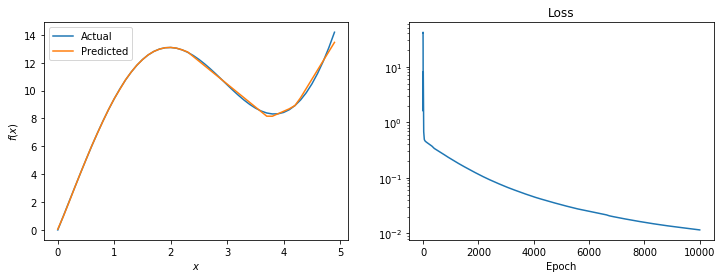

In [15]:
plot_results(x, y, Z, losses)

## Custom step-size decrease schedule 

In [16]:
# training data
x = np.arange(0, 5, 0.1)
y = (x ** 2 + 10*np.sin(x))
x2d = np.concatenate([x, np.ones(x.shape)]).reshape(2, -1).T

# transition function
f, delta_f = get_transition_func("ReLU")

# initialize weights, historical gradients, losses
weights = initweights([2,200,1])
losses = np.zeros(M)

hist_grad = np.copy(weights)
for j in range(len(weights)):
    hist_grad[j] = hist_grad[j] * 0

alpha = 0.02
M = 10000
beta = 0.8
eps = 1e-6

losses = np.zeros(M)
t0 = time.time()
for i in range(M):
    f, delta_f = get_transition_func("ReLU")
    A, Z = forward_pass(weights, x2d, f)
    losses[i] = compute_loss(Z,y)
    gradients = backprop(weights,A,Z,y,delta_f)
    for j in range(len(weights)):
        if i != 0:
            hist_grad[j] = beta * hist_grad[j] + (1 - beta) * gradients[j] ** 2
        else:
            hist_grad[j] = gradients[j] ** 2
        adj_grad = gradients[j] / (eps + np.sqrt(hist_grad[j]))
        weights[j] -= alpha * adj_grad
t1 = time.time()
print('Elapsed time: %.2fs (probably faster than Julia)' % (t1-t0))

Elapsed time: 1.23s (probably faster than Julia)


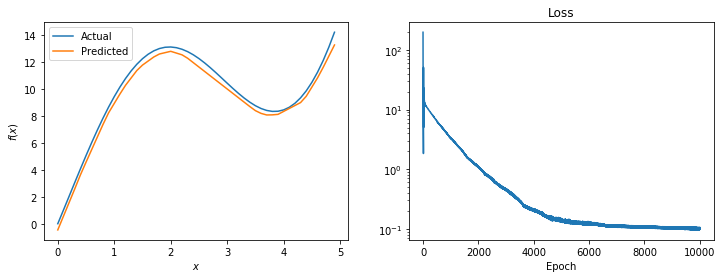

In [17]:
plot_results(x, y, Z, losses)

## Adagrad

In [18]:
# training data
x = np.arange(0, 5, 0.1)
y = (x ** 2 + 10*np.sin(x))
x2d = np.concatenate([x, np.ones(x.shape)]).reshape(2, -1).T

# transition function
f, delta_f = get_transition_func("ReLU")

# initialize weights, historical gradients, losses
weights = initweights([2,200,1])
losses = np.zeros(M)

hist_grad = np.copy(weights)
for j in range(len(weights)):
    hist_grad[j] = hist_grad[j] * 0

alpha = 0.02
M = 10000
beta = 0.8
eps = 1e-6

losses = np.zeros(M)
t0 = time.time()
for i in range(M):
    f, delta_f = get_transition_func("ReLU")
    A, Z = forward_pass(weights, x2d, f)
    losses[i] = compute_loss(Z,y)
    gradients = backprop(weights,A,Z,y,delta_f)
    for j in range(len(weights)):
        hist_grad[j] += gradients[j] ** 2
        adj_grad = gradients[j] / (eps + np.sqrt(hist_grad[j]))
        weights[j] -= alpha * adj_grad
t1 = time.time()
print('Elapsed time: %.2fs (probably faster than Julia)' % (t1-t0))

Elapsed time: 1.07s (probably faster than Julia)


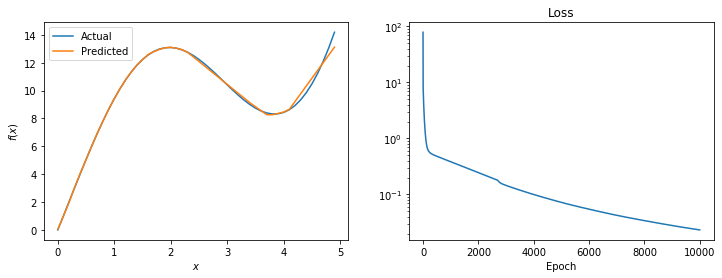

In [19]:
plot_results(x, y, Z, losses)

  <li><p>
  If you did everything correctly, you should be able to pass 
  <pre>
   hw08tests.m
  </pre>
  which checks the gradient of your implementation. 
  </p></li>

  <li><p>
  If you have passed the tests, try out the demo:
  <pre>
  >> functiondemo('ReLU',[30])
  </pre>
  The result should look similar to this image:
  <center>
   <img src="./p08/overfitting.png" width="300px" />
  </center>
   <code>functiondemo.m</code> fits a 1-dimensional function with a neural network. (There is also a 2-dimensional version, <code>xordemo.m</code>.) You can change the transition function by setting the first parameter to 'sigmoid','tanh','ReLU','ReLU2' or 'sin'. You can change the number of hidden layers with the second parameter  -- be careful the array is read backwards (e.g. [30 20] denotes a network with two hidden layers, first 20 hidden nodes followed by 30 hidden nodes). If you want to you can also add your own crazy transition functions into <code>get_transition_func.m</code>. You can verify the gradient of your new transition functions with the command
   <pre>
   checkgrad('transcheck',2,1e-05,'tanh')
   </pre>
   where you need to substitute the name of your own function in for 'tanh'. 
    </li>    